In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from modules import torch_classes
from torchvision import transforms, utils
#from modules.grad_cam_new import *
from modules.grad_cam import *
import matplotlib as mpl
from tqdm import tqdm
import pickle

print(mpl.rcParams["image.cmap"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

viridis
cuda:0


In [2]:
# net = torch_classes.Net(num_of_classes=33) #Initial
# net = torch_classes.Net2(num_of_classes=33) #Sequential model - no weights for it currently
net = torch_classes.Net3(num_of_classes=33) #nn.relu, can hook specific one

#Load trained network weights.
net.load_state_dict(torch.load('CV_file/es_weights/final_weights.pt'))

net.to(device)
net.double()
net.eval()

# from torchvision import datasets, models, transforms
# model_ft = models.resnet152(pretrained=True)
# model_ft

Net3(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2D): Dropout2d(p=0.25)
  (vp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=33, bias=True)
)

In [3]:
#Train set
labels_path = '../DATA/train_labels.pkl'
data_path = 'train.dat'
data_dims = (8269,10404)
genes_path = 'train.csv'

#Data and labels
train = torch_classes.TumorDataset(labels_path,data_path,data_dims,genes_path,transform = transforms.Compose([torch_classes.ToImage(),torch_classes.ToTensor()]))

#Test set
labels_path = '../DATA/test_labels.pkl'
data_path = 'test.dat'
data_dims = (2085,10404)
genes_path = 'test.csv'

test = torch_classes.TumorDataset(labels_path,data_path,data_dims,genes_path,transform = transforms.Compose([torch_classes.ToImage(),torch_classes.ToTensor()]))

In [4]:
cancer_names = [['ACC', '79'],
['BLCA', '408'],
['BRCA', '1100'],
['CESC', '306'],
['CHOL', '36'],
['COAD', '478'],
['DLBC', '48'],
['ESCA', '185'],
['GBM', '166'],
['HNSC', '522'],
['KICH', '66'],
['KIRC', '534'],
['KIRP', '291'],
['LAML', '173'],
['LGG', '530'],
['LIHC', '373'],
['LUAD', '517'],
['LUSC', '501'],
['MESO', '87'],
['OV', '307'],
['PAAD', '179'],
['PCPG', '184'],
['PRAD', '498'],
['READ', '167'],
['SARC', '263'],
['SKCM', '472'],
['STAD', '415'],
['TGCT', '156'],
['THCA', '509'],
['THYM', '120'],
['UCEC', '547'],
['UCS', '57'],
['UVM', '80']]

In [5]:
classes = range(0,34)

In [6]:
print("Total in class samples")
print(np.sum(test.labels,axis=0)+np.sum(train.labels,axis=0))
trn_class_nums = np.sum(train.labels,axis=0)
tst_class_nums = np.sum(test.labels,axis=0)

Total in class samples
[  79  408 1100  306   36  478   48  185  166  522   66  534  291  173
  530  373  517  501   87  307  179  184  498  167  263  472  415  156
  509  120  547   57   80]


### Average image over train set

In [56]:
#Method to calculate the average image per class
total_samples = 0
avg_class_imgs = []
for i in range(33):
    img = 0
    #labels = 0
    for trn_i in range(total_samples,total_samples+trn_class_nums[i]):
        img = img + train.get_data(trn_i)['data'].numpy()
        #labels = labels + train.get_data(trn_i)['label'].numpy() #Sanity check
    
    #print(labels)
    avg_class_imgs.append(img/trn_class_nums[i])
    total_samples = total_samples + trn_class_nums[i]

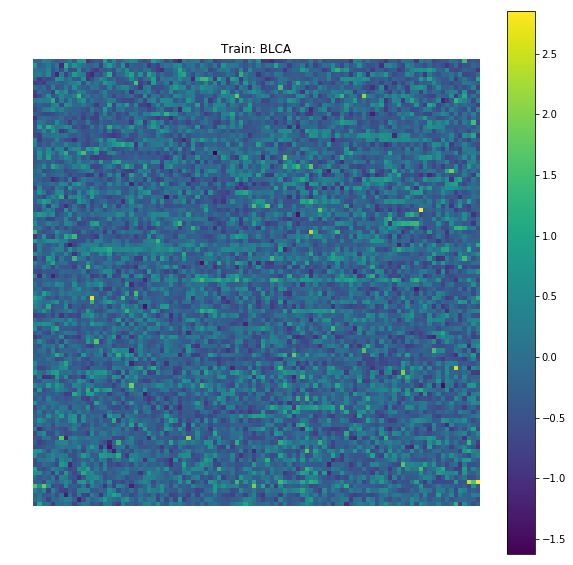

In [148]:
# fig = plt.figure()
# for i, img in enumerate(avg_class_imgs):
#     plt.subplot(11,3,i+1)
#     plt.axis('off')
#     plt.imshow(img)
#     plt.title(cancer_names[i][0])
    
# fig.set_size_inches(20, 80)

j = 1
fig = plt.figure()
plt.imshow(avg_class_imgs[j])
plt.colorbar()
plt.title('Train: '+cancer_names[j][0])
plt.axis('off')
fig.set_size_inches(10,10)

### Saving all average train images

In [147]:
for i, image in enumerate(avg_class_imgs):
    fig = plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.title('Train: '+cancer_names[i][0])
    plt.axis('off')
    fig.set_size_inches(10,10)
    fig.savefig('Average_train/average_train_'+cancer_names[i][0]+'.png')
    plt.close(fig)

### Average image over test set

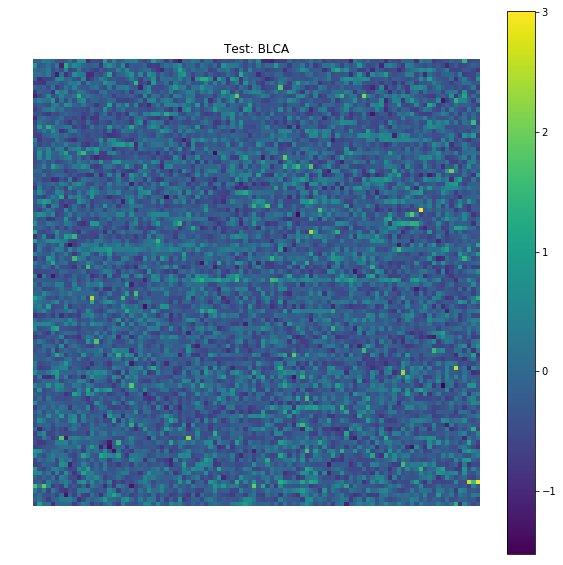

In [149]:
#Method to calculate the average image per class
total_samples = 0
avg_tst_imgs = []
for i in range(33):
    img = 0
    #labels = 0
    for tst_i in range(total_samples,total_samples+tst_class_nums[i]):
        img = img + test.get_data(tst_i)['data'].numpy()
        #labels = labels + test.get_data(tst_i)['label'].numpy() #Sanity check
    
    #print(labels)
    avg_tst_imgs.append(img/tst_class_nums[i])
    total_samples = total_samples + tst_class_nums[i]
    
fig = plt.figure()
plt.imshow(avg_tst_imgs[j])
plt.colorbar()
plt.title('Test: '+cancer_names[j][0])
plt.axis('off')
fig.set_size_inches(10,10)


### Saving all average test images

In [150]:
for i, image in enumerate(avg_tst_imgs):
    fig = plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.title('Test: '+cancer_names[i][0])
    plt.axis('off')
    fig.set_size_inches(10,10)
    fig.savefig('Average_test/average_test_'+cancer_names[i][0]+'.png')
    plt.close(fig)

### NEW Grad-cam library has batch processing for images

In [10]:
net

Net3(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2D): Dropout2d(p=0.25)
  (vp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=33, bias=True)
)

### Calculating average guided grad-cam map for each class in testing set

In [11]:
tst_class_nums

array([ 16,  82, 220,  62,   8,  96,  10,  37,  34, 105,  14, 107,  59,
        35, 106,  75, 104, 101,  18,  62,  36,  37, 100,  34,  53,  95,
        83,  32, 102,  24, 110,  12,  16])

In [ ]:
#https://matplotlib.org/gallery/images_contours_and_fields/image_transparency_blend.html

In [7]:
import time

start = time.time()

target_layer = 'relu3' 
#final convolution layer - best compromise between high-level semantics and detailed spatial information
#but it takes the size of the convolutional filters at that level, hence downsampled image
#hence you use the guided back prop to remap to original space
gcam = GradCAM(model=net)
gbp = GuidedBackPropagation(model=net)

exitFlag = 0
total_samples = 0
avg_cam_maps=[]
for i in range(33):
    running_cam = 0
    for tst_i in tqdm(range(total_samples,total_samples+tst_class_nums[i])):
        im = test.get_data(tst_i)
        image = im['data'].unsqueeze(dim=0).unsqueeze(dim=0)
        image = image.to(device)
        predictions = gcam.forward(image)
        _ = gbp.forward(image)
        top_class = np.argmax(im['label'].numpy())
        #top_class = predictions[0][1]

        #Grad Cam section
        #gcam.backward(ids=top_class) #predictions are ordered from most confident to least-> genersting for most confident class
        gcam.backward(idx=top_class)
        region = gcam.generate(target_layer=target_layer)

        #guided backprop
        #gbp.backward(ids=top_class)
        gbp.backward(idx=top_class)
        gradient = gbp.generate()

        # Guided Grad-CAM
        h, w, _ = gradient.shape
        region = cv2.resize(region, (w, h))[..., np.newaxis]
        output = (gradient * region).squeeze()

        if (np.isnan(output)).any():
            exitFlag = 1
            print("NAN")
            break
        if (np.isnan(running_cam)).any():
            exitFlag = 1
            print("NAN")
            break

        #Averaging grad-cam maps
        running_cam = running_cam + output

#     fig = plt.figure()
#     plt.imshow(running_cam/tst_class_nums[i])
#     plt.colorbar()
#     plt.title('Guided grad-cam: '+cancer_names[i][0])
#     plt.axis('off')
#     fig.set_size_inches(10,10)
#     plt.show()
        
    if exitFlag:
        break
    print("finished class{}".format(i))

    
    avg_cam_maps.append(running_cam/tst_class_nums[i])
    total_samples = total_samples + tst_class_nums[i]
    
print(time.time()-start)

  0%|          | 0/82 [00:00<?, ?it/s]

finished class0


  0%|          | 0/220 [00:00<?, ?it/s]

finished class1


  0%|          | 0/62 [00:00<?, ?it/s]

finished class2


  0%|          | 0/8 [00:00<?, ?it/s]

finished class3


  0%|          | 0/96 [00:00<?, ?it/s]

finished class4


  0%|          | 0/10 [00:00<?, ?it/s]

finished class5


  0%|          | 0/37 [00:00<?, ?it/s]

finished class6


  0%|          | 0/34 [00:00<?, ?it/s]

finished class7


  0%|          | 0/105 [00:00<?, ?it/s]

finished class8


  0%|          | 0/14 [00:00<?, ?it/s]

finished class9


  0%|          | 0/107 [00:00<?, ?it/s]

finished class10


  0%|          | 0/59 [00:00<?, ?it/s]

finished class11


  0%|          | 0/35 [00:00<?, ?it/s]

finished class12


  0%|          | 0/106 [00:00<?, ?it/s]

finished class13


  0%|          | 0/75 [00:00<?, ?it/s]

finished class14


  0%|          | 0/104 [00:00<?, ?it/s]

finished class15


  0%|          | 0/101 [00:00<?, ?it/s]

finished class16


  0%|          | 0/18 [00:00<?, ?it/s]

finished class17


  0%|          | 0/62 [00:00<?, ?it/s]

finished class18


  0%|          | 0/36 [00:00<?, ?it/s]

finished class19


  0%|          | 0/37 [00:00<?, ?it/s]

finished class20


  0%|          | 0/100 [00:00<?, ?it/s]

finished class21


  0%|          | 0/34 [00:00<?, ?it/s]

finished class22


  0%|          | 0/53 [00:00<?, ?it/s]

finished class23


  0%|          | 0/95 [00:00<?, ?it/s]

finished class24


  0%|          | 0/83 [00:00<?, ?it/s]

finished class25


  0%|          | 0/32 [00:00<?, ?it/s]

finished class26


  0%|          | 0/102 [00:00<?, ?it/s]

finished class27


  0%|          | 0/24 [00:00<?, ?it/s]

finished class28


  0%|          | 0/110 [00:00<?, ?it/s]

finished class29


  0%|          | 0/12 [00:00<?, ?it/s]

finished class30


  0%|          | 0/16 [00:00<?, ?it/s]

finished class31


100%|██████████| 16/16 [00:03<00:00,  4.55it/s]

finished class32
457.48632431030273


### Saving all test cam-maps

In [12]:
with open('Average_ggcam/avg_cam_maps.pkl', 'wb') as f:
    pickle.dump(avg_cam_maps, f)

In [8]:
for i, image in enumerate(avg_cam_maps):
    fig = plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.title('Guided grad-cam: '+cancer_names[i][0])
    plt.axis('off')
    fig.set_size_inches(10,10)
    fig.savefig('Average_ggcam/average_ggcam'+cancer_names[i][0]+'.png')
    plt.close(fig)

### Try averaging all train images as well

In [9]:
target_layer = 'relu3' 
#final convolution layer - best compromise between high-level semantics and detailed spatial information
#but it takes the size of the convolutional filters at that level, hence downsampled image
#hence you use the guided back prop to remap to original space
gcam = GradCAM(model=net)
gbp = GuidedBackPropagation(model=net)

exitFlag = 0
total_samples = 0
avg_cam_maps_trn=[]
for i in range(33):
    running_cam = 0
    for trn_i in tqdm(range(total_samples,total_samples+trn_class_nums[i])):
        im = train.get_data(trn_i)
        image = im['data'].unsqueeze(dim=0).unsqueeze(dim=0)
        image = image.to(device)
        predictions = gcam.forward(image)
        _ = gbp.forward(image)
        top_class = np.argmax(im['label'].numpy())
        #top_class = predictions[0][1]

        #Grad Cam section
        #gcam.backward(ids=top_class) #predictions are ordered from most confident to least-> genersting for most confident class
        gcam.backward(idx=top_class)
        region = gcam.generate(target_layer=target_layer)

        #guided backprop
        #gbp.backward(ids=top_class)
        gbp.backward(idx=top_class)
        gradient = gbp.generate()

        # Guided Grad-CAM
        h, w, _ = gradient.shape
        region = cv2.resize(region, (w, h))[..., np.newaxis]
        output = (gradient * region).squeeze()
        
        #Averaging grad-cam maps
        running_cam = running_cam + output
        
    avg_cam_maps_trn.append(running_cam/trn_class_nums[i])
    total_samples = total_samples + trn_class_nums[i]

100%|██████████| 64/64 [00:13<00:00,  4.61it/s]


In [18]:
with open('Average_ggcam_train/avg_cam_maps_trn.pkl', 'wb') as f:
    pickle.dump(avg_cam_maps_trn, f)

In [10]:
for i, image in enumerate(avg_cam_maps_trn):
    fig = plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.title('Guided grad-cam: '+cancer_names[i][0])
    plt.axis('off')
    fig.set_size_inches(10,10)
    fig.savefig('Average_ggcam_train/average_ggcam_trn'+cancer_names[i][0]+'.png')
    plt.close(fig)

### Plotting all cams

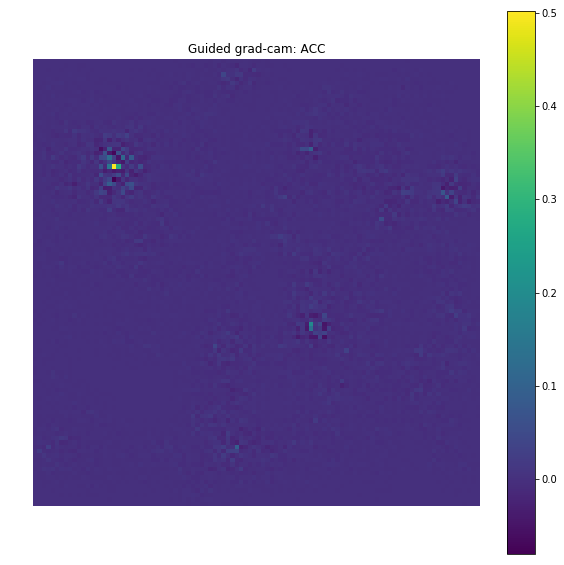

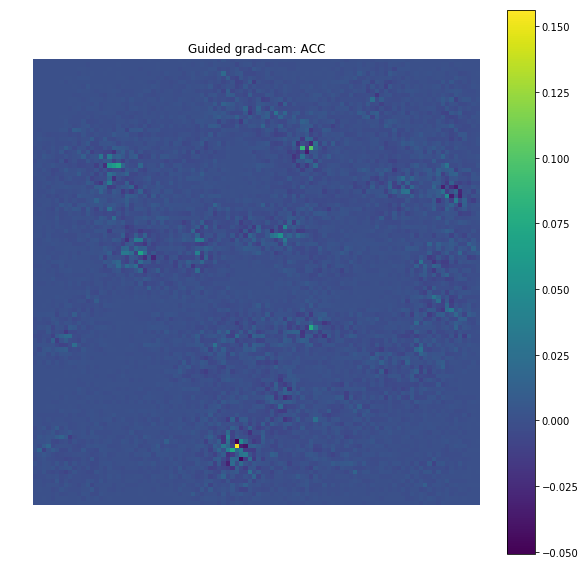

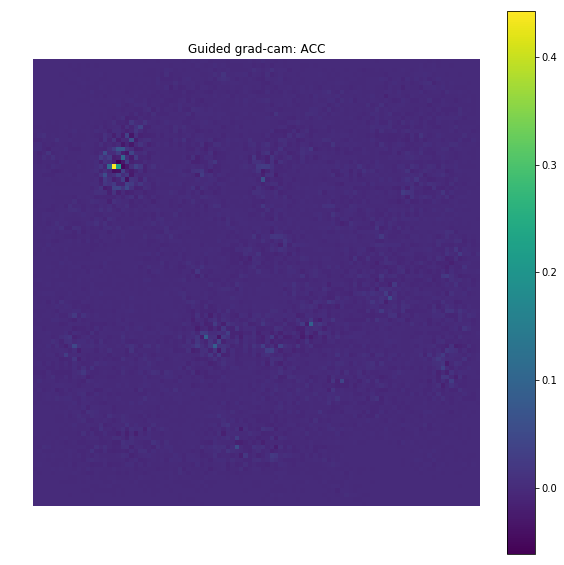

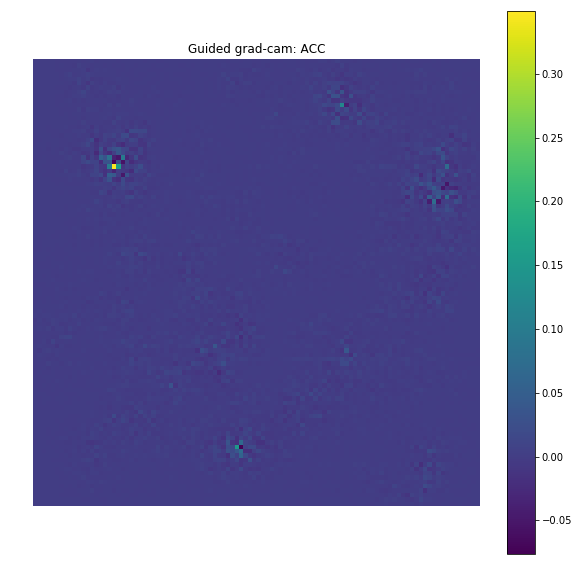

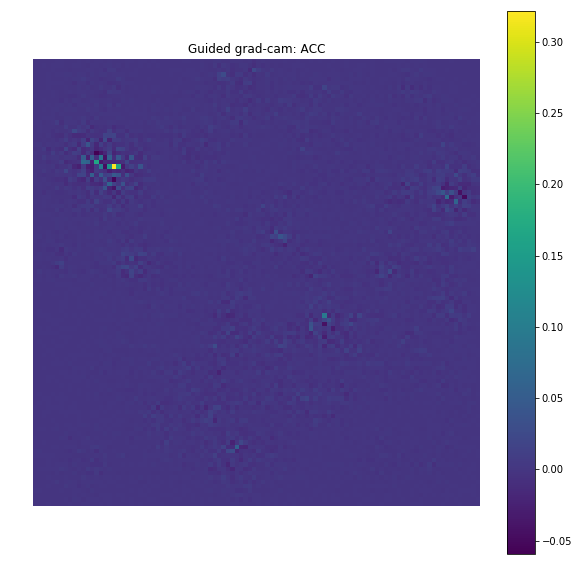

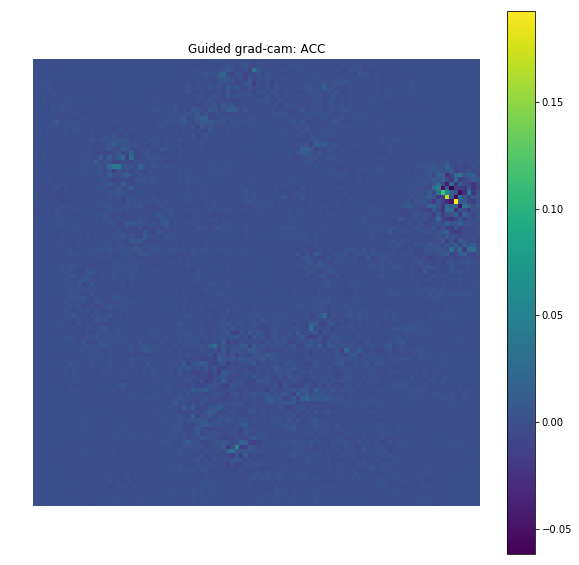

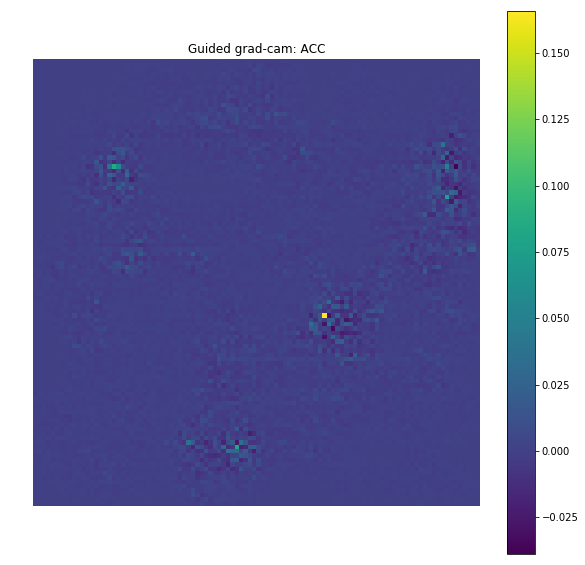

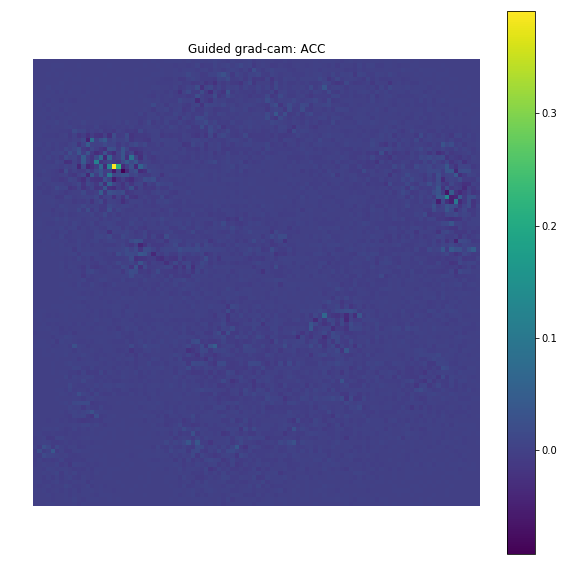

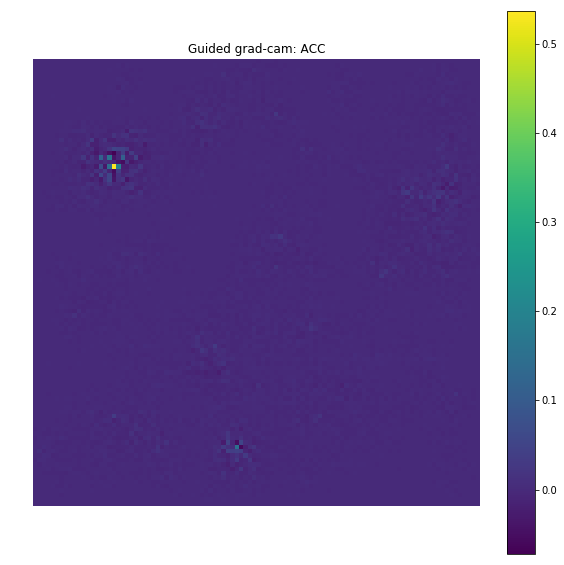

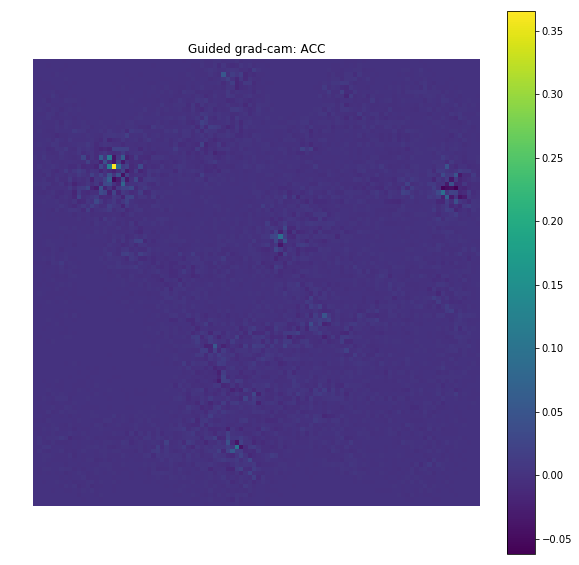

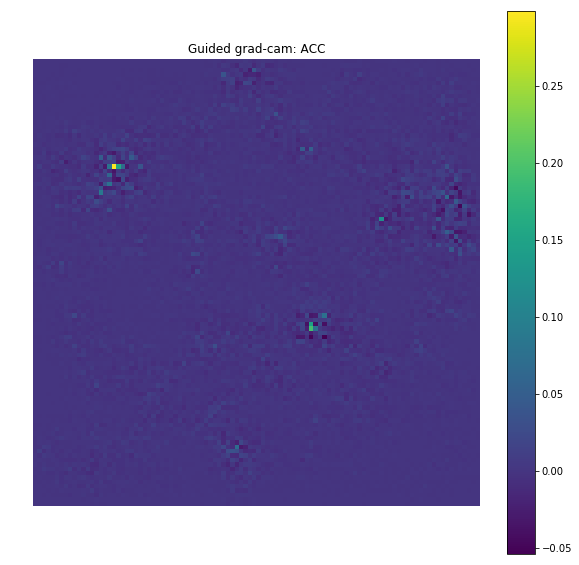

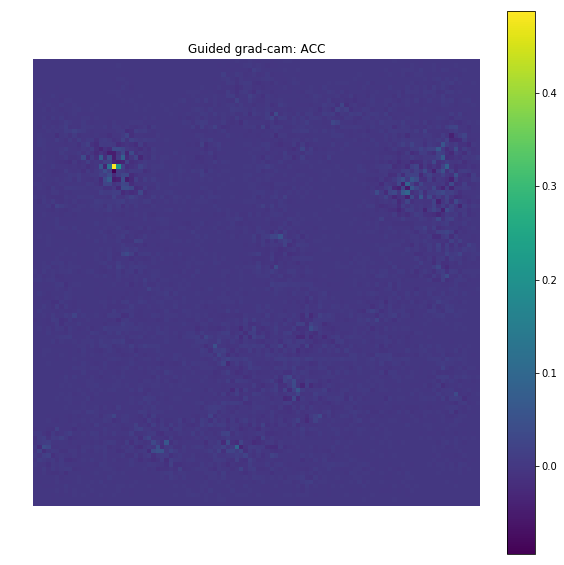

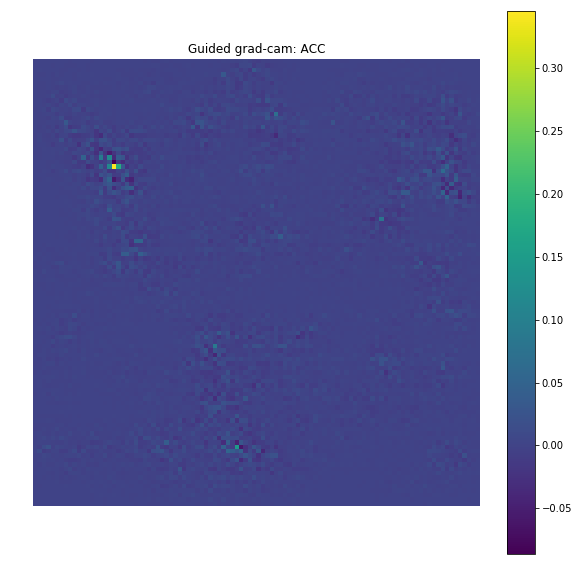

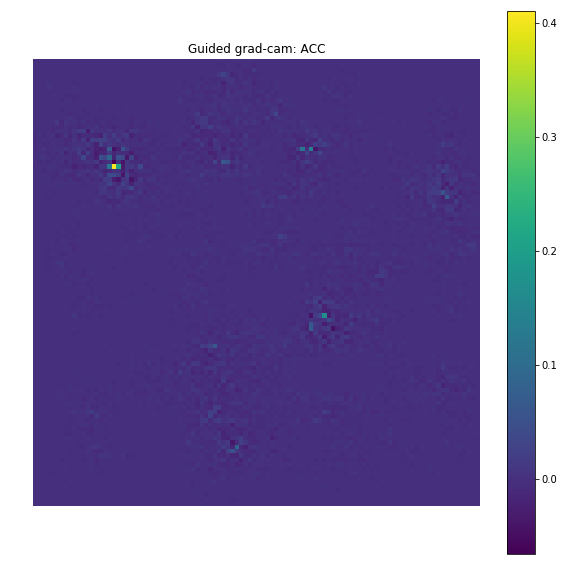

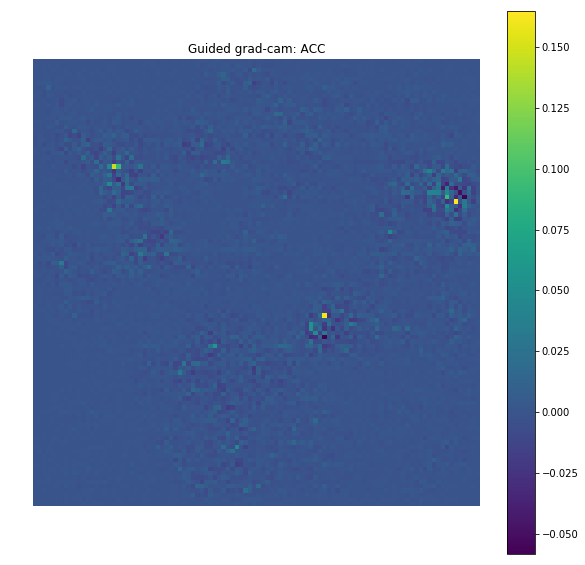

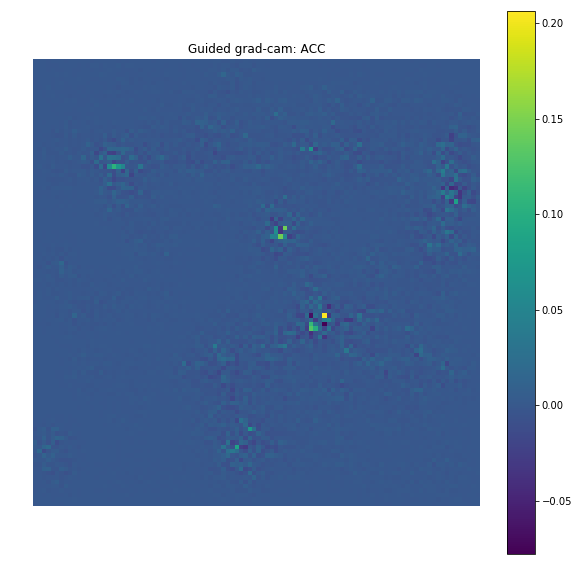

In [23]:
gcam = GradCAM(model=net)
gbp = GuidedBackPropagation(model=net)
for i in range(16):
    img = test.get_data(i) #get which sample, only call one at a time
    image = img['data'].unsqueeze(dim=0).unsqueeze(dim=0)
    label = np.argmax(img['label'].cpu().numpy())
    image = image.to(device)

    prediction = gcam.forward(image)
    _ = gbp.forward(image)

    target_layer = 'relu3'


    # Grad-CAM
    gcam.backward(idx=prediction[0][1])
    region = gcam.generate(target_layer=target_layer)

    # Guided Backpropagation
    gbp.backward(idx=prediction[0][1])
    gradient = gbp.generate()

    # Guided Grad-CAM
    h, w, _ = gradient.shape
    region = cv2.resize(region, (w, h))[..., np.newaxis]
    output = (gradient * region).squeeze()


    fig = plt.figure()
    plt.imshow(output)
    plt.title('Guided grad-cam: '+cancer_names[label][0])

    plt.colorbar()
    plt.axis('off')
    fig.set_size_inches(10,10)